In [3]:
from src.database.base import init_db, get_db_session
from src.utils.config import settings

from src.ingestion.ingestion_helpers import ingest_financial_data

from src.ingestion.edgar_db.accessors import edgar_login, get_10k_filing, get_company
import matplotlib.pyplot as plt

from src.database.companies import list_all_companies
from src.database.filings import Filing
from src.database.financial_concepts import FinancialConcept
import pandas as pd
from src.database.filings import get_filings_by_company
from src.database.companies import get_company_by_ticker
from src.database.financial_values import FinancialValue
init_db(settings.database.url)
session = get_db_session()


2025-07-02 00:35:32 [info     ] database_initialized           status=success


In [ ]:


# Query all financial concepts and convert to DataFrame
financial_concepts = session.query(FinancialConcept).all()

# Convert to list of dictionaries
concepts_data = []
for concept in financial_concepts:
    concept_dict = {column.name: getattr(concept, column.name) for column in concept.__table__.columns}
    concepts_data.append(concept_dict)

# Create DataFrame
df = pd.DataFrame(concepts_data)

In [ ]:


# Get Microsoft company
msft_company = get_company_by_ticker('MSFT')
if msft_company:
    print(f"Found Microsoft: {msft_company}")

    # Get all filings for Microsoft
    msft_filings = get_filings_by_company(msft_company.id)

    # Filter for 2024 10-K filings
    msft_2024_10k = [filing for filing in msft_filings
                     if filing.filing_type == '10-K' and filing.filing_date.year == 2024]

    if msft_2024_10k:
        filing = msft_2024_10k[0]  # Get the first (likely only) 2024 10-K
        print(f"Found 2024 10-K filing: {filing}")
        print(f"Filing Date: {filing.filing_date}")
        print(f"Accession Number: {filing.accession_number}")
        print(f"Period of Report: {filing.period_of_report}")
    else:
        print("No 2024 10-K filing found for Microsoft")
        # Show available filings for context
        print(f"Available filings: {len(msft_filings)}")
        for filing in msft_filings[:5]:  # Show first 5 filings
            print(f"  {filing.filing_type} - {filing.filing_date}")
else:
    print("Microsoft (MSFT) not found in database")

2025-07-02 00:06:07 [info     ] retrieved_company_by_ticker    company_id=0685e2b2-ba5f-73a8-8000-6d5063ab6d43 ticker=MSFT
Found Microsoft: <Company(id=0685e2b2-ba5f-73a8-8000-6d5063ab6d43, name='MICROSOFT CORP', cik='789019')>
2025-07-02 00:06:07 [info     ] retrieved_filings_by_company   company_id=0685e2b2-ba5f-73a8-8000-6d5063ab6d43 count=4
Found 2024 10-K filing: <Filing(id=0685e2b5-ff23-739b-8000-30f51ca878b7, company_id=0685e2b2-ba5f-73a8-8000-6d5063ab6d43, accession_number='0000950170-24-087843')>
Filing Date: 2024-07-30
Accession Number: 0000950170-24-087843
Period of Report: 2024-06-30


In [ ]:


# Query all financial values for the Microsoft 2024 10-K filing
financial_values = session.query(FinancialValue).filter(
    FinancialValue.filing_id == filing.id
).join(FinancialConcept).all()

# Convert to list of dictionaries with concept name, description, and value
values_data = []
for fv in financial_values:
    values_data.append({
        'concept_name': fv.concept.name,
        'description': fv.concept.description,
        'value': fv.value
    })

# Create DataFrame
values_df = pd.DataFrame(values_data)
print(f"Found {len(values_df)} financial values for Microsoft 2024 10-K filing")
values_df.head(10)

Found 78 financial values for Microsoft 2024 10-K filing


,concept_name,description,value
0,us-gaap_CashAndCashEquivalentsAtCarryingValue,Cash and Cash Equivalents,13931000000.0000000000
1,us-gaap_ShortTermInvestments,Short-term investments,90826000000.0000000000
2,us-gaap_CashCashEquivalentsAndShortTermInvestm...,Cash and Cash Equivalents,104757000000.0000000000
3,us-gaap_AccountsReceivableNetCurrent,Accounts Receivable,44261000000.0000000000
4,us-gaap_InventoryNet,Inventory,3742000000.0000000000
5,us-gaap_OtherAssetsCurrent,Other Assets,16924000000.0000000000
6,us-gaap_AssetsCurrent,Total Current Assets,169684000000.0000000000
7,us-gaap_PropertyPlantAndEquipmentNet,"Property, Plant and Equipment",74398000000.0000000000
8,us-gaap_OperatingLeaseRightOfUseAsset,Operating lease right-of-use assets,13148000000.0000000000
9,us-gaap_LongTermInvestments,Long-Term Investments,6891000000.0000000000


In [11]:


company = get_company_by_ticker("GOOGL")
all_filings = get_filings_by_company(company.id)


# Get all financial values with their concepts and filing dates
time_series_data = []
for filing in all_filings:
    filing_year = filing.filing_date.year
    financial_values = session.query(FinancialValue).filter(
        FinancialValue.filing_id == filing.id
    ).join(FinancialConcept).all()

    for fv in financial_values:
        time_series_data.append({
            'concept_name': fv.concept.name,
            'description': fv.concept.description,
            'value': fv.value,
            'filing_year': filing_year,
            'filing_date': filing.filing_date
        })

# Create DataFrame
time_series_df = pd.DataFrame(time_series_data)

# Pivot to get years as columns
if not time_series_df.empty:
    pivot_df = time_series_df.pivot_table(
        index=['concept_name', 'description'],
        columns='filing_year',
        values='value',
        aggfunc='first'
    ).reset_index()

    # Clean up column names
    pivot_df.columns.name = None
    year_columns = [col for col in pivot_df.columns if isinstance(col, int)]
    other_columns = [col for col in pivot_df.columns if not isinstance(col, int)]

    print(f"Found financial data across {len(year_columns)} years: {sorted(year_columns)}")
    print(f"Total concepts: {len(pivot_df)}")
    pivot_df.head()


2025-07-02 00:56:32 [info     ] retrieved_company_by_ticker    company_id=0685e290-2202-7cb1-8000-dbf004637dd0 ticker=GOOGL
2025-07-02 00:56:32 [info     ] retrieved_filings_by_company   company_id=0685e290-2202-7cb1-8000-dbf004637dd0 count=5
Found financial data across 1 years: [2025]
Total concepts: 78


In [12]:
pivot_df

,concept_name,description,2025
0,goog_AccruedRevenueShare,Accrued revenue share,8370000000.0000000000
1,goog_AcquisitionsNetOfCashAcquiredAndPurchases...,"Acquisitions, net of cash acquired, and purcha...",6969000000.0000000000
2,goog_AmortizationAndImpairmentOfIntangibleAssets,Amortization and impairment of intangible assets,641000000.0000000000
3,goog_DepreciationAndImpairmentOnDispositionOfP...,Depreciation and impairment of property and eq...,15287000000.0000000000
4,goog_IncreaseDecreaseInAccruedRevenueShare,Accrued revenue share,-445000000.0000000000
...,...,...,...
73,us-gaap_RetainedEarningsAccumulatedDeficit,Retained Earnings,195563000000.0000000000
74,us-gaap_RevenueFromContractWithCustomerExcludi...,Revenue,282836000000.0000000000
75,us-gaap_SellingAndMarketingExpense,"Selling, General and Administrative Expense",26567000000.0000000000
76,us-gaap_ShareBasedCompensation,Stock-based compensation,19362000000.0000000000


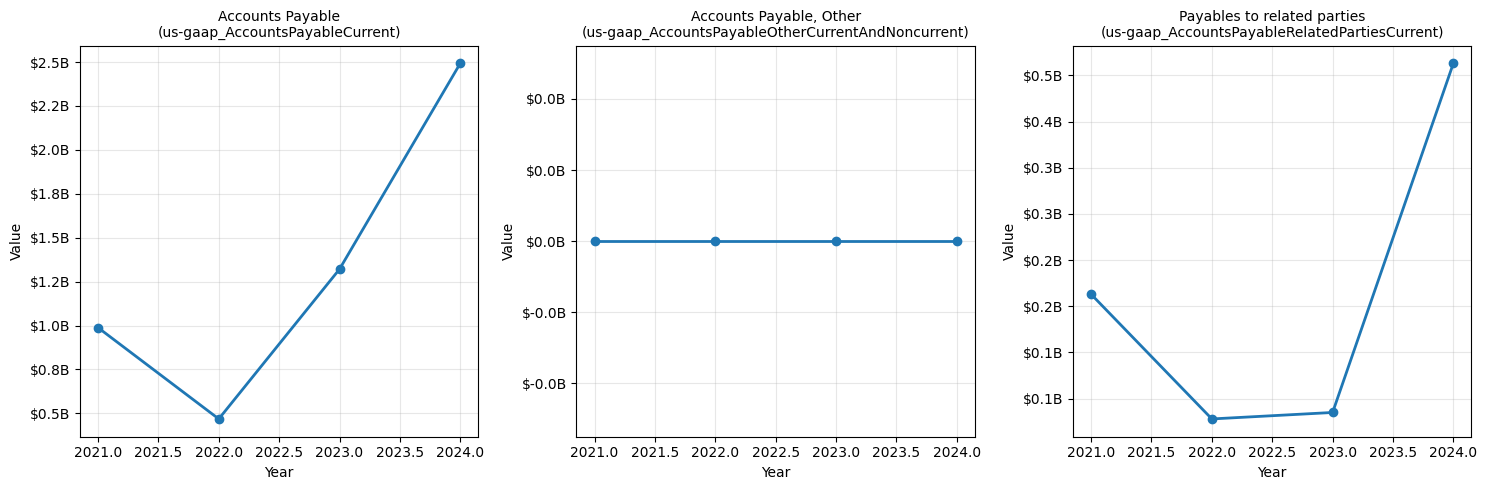

In [10]:

# Get the first 3 concepts from pivot_df
first_3_concepts = pivot_df[pivot_df['concept_name'].str.startswith('us-gaap')].head(3)

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each concept
for i, (idx, row) in enumerate(first_3_concepts.iterrows()):
    concept_name = row['concept_name']
    description = row['description']

    # Get year columns and their values
    years = [2021, 2022, 2023, 2024]
    values = [float(row[year]) if pd.notna(row[year]) else 0 for year in years]

    # Create the plot
    axes[i].plot(years, values, marker='o', linewidth=2, markersize=6)
    axes[i].set_title(f"{description}\n({concept_name})", fontsize=10)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

    # Format y-axis to show values in billions
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))

plt.tight_layout()
plt.show()